In [1]:
def install_lib(libname):
    print(f">>> {libname}")
    get_ipython().system(f"pip install -qqq {libname}")

libs = [
        "accelerate==0.29.3"
]

for lib in libs:
    install_lib(lib)

>>> accelerate==0.29.3


In [1]:
import os
import torch

from huggingface_hub import login
from sentence_transformers import SentenceTransformer
from datasets import load_dataset, concatenate_datasets

from sentence_transformers.util import cos_sim
from sentence_transformers.evaluation import (
    InformationRetrievalEvaluator,
    SequentialEvaluator,
)

/opt/conda/lib/python3.10/site-packages/transformers/utils/hub.py:124: FutureWarning: Using `TRANSFORMERS_CACHE` is deprecated and will be removed in v5 of Transformers. Use `HF_HOME` instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torch/cuda/__init__.py:619: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")
No CUDA runtime is found, using CUDA_HOME='/usr/local/cuda'


In [2]:
login(token=os.environ["HUGGINGFACE_TOKEN"])

# MODEL_ID = 'PORTULAN/serafim-900m-portuguese-pt-sentence-encoder-ir'
MODEL_ID = "BAAI/bge-small-en-v1.5"
MATRYOSHKA_DIMENSIONS = [384, 256, 128, 64] # [768, 512, 256, 128, 64]
TRAIN_DATASET = "data/bacen/train_dataset.json"
TEST_DATASET = "data/bacen/test_dataset.json"

The token has not been saved to the git credentials helper. Pass `add_to_git_credential=True` in this function directly or `--add-to-git-credential` if using via `huggingface-cli` if you want to set the git credential as well.
Token is valid (permission: read).
Your token has been saved to /root/.cache/huggingface/token
Login successful


## 1. Crie e Prepare o Conjunto de Dados de Incorporação

Um conjunto de dados de embedding geralmente consiste em pares de texto (pergunta, resposta/contexto) ou tríades que representam relações ou semelhanças entre frases. O formato do conjunto de dados que você escolher ou tiver disponível também afetará a função de perda que você pode usar. Formatos comuns para conjuntos de dados de embedding:

- **Par Positivo**: Pares de texto de frases relacionadas (consulta, contexto | consulta, resposta), adequados para tarefas como pesquisa de semelhança ou busca semântica, exemplos de conjuntos de dados: `sentence-transformers/sentence-compression`, `sentence-transformers/natural-questions`.
- **Tríades**: Tríades de texto compostas por (âncora, positivo, negativo), exemplos de conjuntos de dados `sentence-transformers/quora-duplicates`, `nirantk/triplets`.
- **Par com Pontuação de Similaridade**: Pares de frases com uma pontuação de similaridade indicando o quão relacionadas são, exemplos de conjuntos de dados: `sentence-transformers/stsb`, `PhilipMay/stsb_multi_mt`

Saiba mais em [Visão Geral dos Conjuntos de Dados](https://sbert.net/docs/sentence_transformer/dataset_overview.html).

Vamos usar o dataset [Itau-Unibanco/FAQ_BACEN)](https://huggingface.co/datasets/Itau-Unibanco/FAQ_BACEN), que inclui 7.000 pares de texto positivos de perguntas e contextos correspondentes do [Relatório SEC da NVIDIA de 2023_10](https://stocklight.com/stocks/us/nasdaq-nvda/nvidia/annual-reports/nasdaq-nvda-2023-10K-23668751.pdf).

O conjunto de dados tem o seguinte formato:
```json
{"questions": "<pergunta>", "answers": "<contexto relevante para a resposta>"}
{"questions": "<pergunta>", "answers": "<contexto relevante para a resposta>"}
{"questions": "<pergunta>", "answers": "<contexto relevante para a resposta>"}
```

# Dataset

In [4]:
%%time
from datasets import load_from_disk

dataset_filepath = "data/clips_mqa/pt"
dataset = load_from_disk(dataset_filepath)

CPU times: user 49.1 ms, sys: 38.8 ms, total: 87.9 ms
Wall time: 40.1 ms


In [5]:
dataset

Dataset({
    features: ['id', 'bucket', 'domain', 'text', 'question', 'answer'],
    num_rows: 4046601
})

dataset

In [163]:
data = load_dataset("clips/mqa", language="pt")

/opt/conda/lib/python3.10/site-packages/datasets/load.py:1491: FutureWarning: The repository for clips/mqa contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at https://hf.co/datasets/clips/mqa
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this dataset from the next major release of `datasets`.
  warnings.warn(


In [164]:
data

DatasetDict({
    train: Dataset({
        features: ['id', 'text', 'name', 'domain', 'bucket', 'answers'],
        num_rows: 6218943
    })
})

In [88]:
import re
import unicodedata

from datasets import load_from_disk

load_from_hub = True

dataset_filepath = "data/clips_mqa/pt"

blacklist_domains = [
    "ti-enxame.com",
]

prohibited_terms = ["href", "https", "www.", ".html", "volumen caps"]


def format_dataset(row):
    return {
        "id": row["id"],
        "question": row["name"],
        "domain": row["domain"],
        "answer": row["answers"][0]["text"],
    }

def contains_prohibited_term_regex(text):
    pattern = re.compile("|".join(map(re.escape, prohibited_terms)))
    return bool(pattern.search(text))

def remove_links(text):
    url_regex = r'http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\\(\\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+'
    return re.sub(url_regex, '', text)

def remove_non_alphanumeric(text):
    return re.sub(r'[^\w\s.,!?;:\'\"-]', '', text)

def remove_long_words(text, max_length=15):
    # Expressão regular para encontrar substrings com mais de 15 caracteres consecutivos
    pattern = r'\S{' + str(max_length + 1) + r',}'
    # Substituir as substrings que correspondem ao padrão por uma string vazia
    cleaned_text = re.sub(pattern, '', text)
    return cleaned_text

def check_if_question_is_big_enough(text):
    if len(text) < 20:
        return False
    elif 20 <= len(text) <= 30:
        if "?" in text[-3:]:
            return True
        return False
    return True


def format_text_fields(text):
    text = unicodedata.normalize("NFKD", text)
    text = remove_long_words(text)
    text = remove_non_alphanumeric(text)
    text = remove_links(text)
    text = text.replace("--", "")
    text = text.replace("\n", "")
    text = text.replace("](", "")
    text = text.replace(" [", "")
    text = text.strip()
    return text

def format_text(row):
    return {
        "text": format_text_fields(row["text"]),
        "question": format_text_fields(row["question"]),
        "answer": format_text_fields(row["answer"]),
    }


if load_from_hub:
    raw_dataset = load_dataset("clips/mqa", language="pt")["train"]
    raw_dataset = raw_dataset.filter(lambda row: row["answers"][0]["is_accepted"] == True)
    raw_dataset = raw_dataset.filter(lambda row: row["domain"] not in blacklist_domains)
    raw_dataset = raw_dataset.filter(lambda row: not contains_prohibited_term_regex(row["answers"][0]["text"]) )
    raw_dataset = raw_dataset.filter(lambda row: not contains_prohibited_term_regex(row["name"]) )
    raw_dataset = raw_dataset.filter(lambda row: not contains_prohibited_term_regex(row["text"]) )
    raw_dataset = raw_dataset.filter(lambda row: check_if_question_is_big_enough(row["name"]) )
    raw_dataset = raw_dataset.filter(lambda row: len(row["answers"][0]["text"]) > 0)
    raw_dataset = raw_dataset.map(format_dataset)
    dataset = raw_dataset.map(format_text).select_columns(['id', 'bucket', 'domain', 'text', 'question', 'answer'])
    dataset = dataset.filter(lambda row: check_if_question_is_big_enough(row["question"]) )
    dataset.save_to_disk(dataset_filepath)

/opt/conda/lib/python3.10/site-packages/datasets/load.py:1491: FutureWarning: The repository for clips/mqa contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at https://hf.co/datasets/clips/mqa
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this dataset from the next major release of `datasets`.
  warnings.warn(


Filter:   0%|          | 0/5964271 [00:00<?, ? examples/s]

Filter:   0%|          | 0/5961948 [00:00<?, ? examples/s]

Filter:   0%|          | 0/4349835 [00:00<?, ? examples/s]

Filter:   0%|          | 0/4327031 [00:00<?, ? examples/s]

Filter:   0%|          | 0/4321138 [00:00<?, ? examples/s]

Filter:   0%|          | 0/4124504 [00:00<?, ? examples/s]

Map:   0%|          | 0/4124485 [00:00<?, ? examples/s]

Map:   0%|          | 0/4124485 [00:00<?, ? examples/s]

Filter:   0%|          | 0/4124485 [00:00<?, ? examples/s]

Saving the dataset (0/4 shards):   0%|          | 0/4046601 [00:00<?, ? examples/s]

In [89]:
dataset = load_from_disk(dataset_filepath)
df = dataset.to_pandas()

# df["len_question"] = df["name"].str.len()
df["len_question"] = df["question"].str.len()
df["len_answer"] = df["answer"].str.len()

In [102]:
df[((df["text"].str.len() > 0) & (df["text"] != df["question"]))].sample().iloc[0].to_dict()

{'id': '9409a81f11827047b3ba81da780a4373',
 'bucket': '2021.10',
 'domain': 'stackoverflow.com',
 'text': "Eu tenho uma lista que possui dentro dela outra lista com o nome dos alunos, e mais uma lista que foi dividida em mais duas listas, representando a primeira nota e a segunda nota. Por exemplo:'Matheus', 'Julia', 'Eduardo', 9.4, 4.7, 3.2, 7.2, 8.3, 2.4Gostaria de saber o que eu faco para acessar cada nivel dessa lista, para retornar separadamente o nome dos alunos, a sua primeira nota e a segunda nota.Eu tentei da seguinte forma:nome  nota1  nota2  for i in range0, 3:    do Aluno: '    1: '    2: '   print'n'notas  listaAlunos  for i in range0,    for j in range0, 3:",
 'question': 'Como acessar uma lista que esta dentro de outra lista em',
 'answer': 'Existem forma melhores de armazenar seus dados como lista de dicionarios, ou lista de namedtuple. Se o modelo de aluno fosse mais complexo, ainda teria a lista de classes definidas pelo programador.Mas primeiro...Respondendo a pergun

In [ ]:
df[((df["text"].str.len() > 0) & (df["text"] != df["question"]))].sample().iloc[0].to_dict()

In [ ]:
{'id': '73c1cef6e6faa4d025f7d91442a25b50',
 'bucket': '2019.43',
 'domain': 'yahoo.com',
 'text': 'bom desde ja quero desejar uma boa noite a todos vcs e que Deus venha guardar a cada um dos meus amigos e visitantes e si eu magoei alguem eu aproveito para pedir perdao pq o bin bin e terrivel,,,,,um beijo bomba bombom e um abraco dinamite para todos fuiiiiiiiiiii',
 'question': 'Abra que tem um desejo para vc,ou vc nao e corajosoa de entrar aqui?',
 'answer': 'CHEGUEI MEIO ATRASADO, MAS TEM UMA LADO BOM, SOU O PRIMEIRO A OUVIR UM BOA NOITE DE VC HOJE, 25.   UM GRANDE ABRACO MEU AMIGO, E BOA NOITE PRA VC',
 'len_question': 68,
 'len_answer': 145}

In [37]:




# dataset = load_from_disk(dataset_filepath)


# raw_dataset = raw_dataset.shuffle(seed=42).select(range(100000))


# raw_dataset = raw_dataset.select_columns(['anchor', 'positive', 'domain'])


# raw_dataset = load_from_disk(dataset_filepath).select_columns(['anchor', 'positive'])

/opt/conda/lib/python3.10/site-packages/datasets/load.py:1491: FutureWarning: The repository for clips/mqa contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at https://hf.co/datasets/clips/mqa
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this dataset from the next major release of `datasets`.
  warnings.warn(


Filter:   0%|          | 0/95868 [00:00<?, ? examples/s]

Filter:   0%|          | 0/70172 [00:00<?, ? examples/s]

Filter:   0%|          | 0/69822 [00:00<?, ? examples/s]

Filter:   0%|          | 0/69724 [00:00<?, ? examples/s]

Filter:   0%|          | 0/66593 [00:00<?, ? examples/s]

Map:   0%|          | 0/66593 [00:00<?, ? examples/s]

Map:   0%|          | 0/66593 [00:00<?, ? examples/s]

Filter:   0%|          | 0/66593 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/65370 [00:00<?, ? examples/s]

In [39]:
df[df["len_question"] < 30]

,id,bucket,domain,text,question,answer,len_question,len_answer
20,72d34b7230da06257fa77950795fdcb8,2019.51,runrun.it,,o que e canvas online?,o canvas e uma ferramenta usada para definir o...,22,308
21,3807cf84691b3e09c1b27b3fa14f313a,2021.39,hotelscombined.pt,,metro hotel spa tem wi-fi?,"sim, metro hotel spa tem wi-fi disponivel par...",27,57
53,eb4de6d0153eae5b0a9390ebee8036ef,2020.29,kerendo.com,,qual e o preco promocional?,r 126.80,27,8
75,0588f3c3205d2ae641f5c3fbc2e6597d,2020.45,sktecenergia.com.br,,como funciona o nobreak?,o n-break evita que surtos de alta tensao na r...,24,156
103,029e9079479f50be27eb47661ad7504f,2021.43,zankyou.com.br,,qual e o seu diferencial?,"voce podera ter uma celebracao unica, feita a ...",25,231
...,...,...,...,...,...,...,...,...
65217,c328ffe89f9aa4979e4b75ada51e8863,2020.16,vrbo.com,,"Onde ficar em Rong, NO?","Para 2020, temos 65 opcoes de aluguel de tempo...",23,297
65219,b18498eea7ee778caace144bef0ca7fb,2020.45,webcamsex-gratis.nl,,O que e Webcamsex gratis NL?,Webcamsex gratis NL e uma rede de video online...,28,1069
65232,12e30f82c6ae16b6d3ca430344486675,2021.10,guiadacarreira.com.br,,qual a nota do mec da faec?,a faec possui nota 0 no indice geral dos curso...,27,82
65350,59b19aec3c897e1e50012b21fbf0833f,2021.31,viajala.com.br,,quando ir para manaus?,manaus tem duas epocas. a epoca de chuva e de ...,22,314


In [87]:
temp = df[
    (
        (df["len_question"] >= 0)
        & (df["len_question"] <= 30)
    )
].sample(1).iloc[0].to_dict()
temp

{'id': '1ea07a06c11acf15245d0463c709b453',
 'bucket': '2019.51',
 'domain': 'momondo.pt',
 'text': '',
 'question': 'qual e a rota mais barata?',
 'answer': 'voa de bilbao a porto aeroporto francisco sa carneiro pelos melhores precos nos voos bilbau - porto',
 'len_question': 26,
 'len_answer': 99}

In [431]:
raw_dataset = load_dataset("clips/mqa", language="pt")["train"]

raw_dataset = raw_dataset.shuffle(seed=42).select(range(100000))

/opt/conda/lib/python3.10/site-packages/datasets/load.py:1491: FutureWarning: The repository for clips/mqa contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at https://hf.co/datasets/clips/mqa
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this dataset from the next major release of `datasets`.
  warnings.warn(


In [433]:



    
f_dataset = raw_dataset.filter(lambda row: check_if_question_is_big_enough(row["name"]) )

df = f_dataset.to_pandas()

df["len_question"] = df["name"].str.len()

In [434]:
df[df["len_question"] < 10]

,id,text,name,domain,bucket,answers,len_question


In [426]:
temp = df[
    (
        (df["len_question"] >= 0)
        & (df["len_question"] <= 10)
    )
].sample(1).iloc[0].to_dict()
temp

{'id': '9a2ef86b502269ee5973d0bcd56431d7',
 'bucket': '2021.10',
 'domain': 'traduzca.com',
 'text': '',
 'question': 'strongpara',
 'answer': 'para quem deseja concluir os estudos ou fazer uma  em outros paises, as traducoes juramentadas para o ingles de diplomas, historico escolar e certidoes sao fundamentais para que possa ingressar nas universidades. contate a traduzca e conheca nossas solucoes.',
 'len_question': 10,
 'len_answer': 258}

In [417]:
temp = df[
    (
        (df["len_answer"] >= 0)
        & (df["len_answer"] <= 10)
    )
].sample(1).iloc[0].to_dict()
temp

{'id': 'fc53e588c6aa769fe815bd5dcf7604a0',
 'bucket': '2021.04',
 'domain': 'tudosobreprodutos.com.br',
 'text': '',
 'question': ' quem e o fabricante do produto "relogio monitor batimento cardiaco varias funcoes atrio 090"?',
 'answer': 'atrio',
 'len_question': 94,
 'len_answer': 5}

<Axes: >

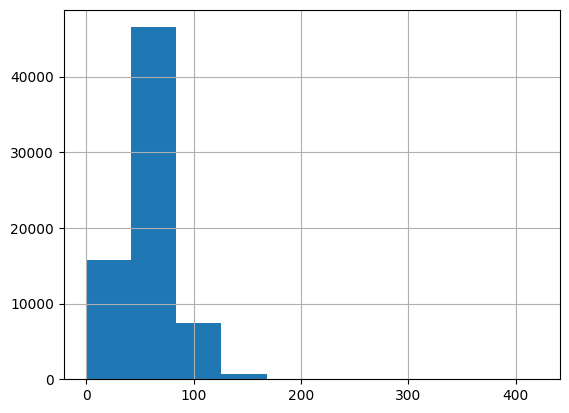

In [322]:
df["len_question"].hist()

In [281]:
# %%time

# import re
# import unicodedata



# def remove_links(text):
#     url_regex = r'http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\\(\\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+'
#     return re.sub(url_regex, '', text)

# def remove_non_alphanumeric(text):
#     return re.sub(r'[^\w\s.,!?;:\'\"-]', '', text)

# def remove_long_words(text, max_length=15):
#     # Expressão regular para encontrar substrings com mais de 15 caracteres consecutivos
#     pattern = r'\S{' + str(max_length + 1) + r',}'
#     # Substituir as substrings que correspondem ao padrão por uma string vazia
#     cleaned_text = re.sub(pattern, '', text)
#     return cleaned_text

# def format_text_fields(text):
#     text = unicodedata.normalize("NFKD",)
#     text = remove_long_words(text)
#     text = remove_non_alphanumeric(text)
#     text = remove_links(text)
#     text = text.replace("--", "")
#     text = text.replace("\n", "")
#     text = text.replace("](", "")
#     text = text.replace(" [", "")

    
#     return text

# def format_text(row):
#     return {
#         "anchor": format_text_fields(row["anchor"]),
#         "positive": format_text_fields(row["positive"]),
#     }

# dataset = raw_dataset.map(format_text)

Map:   0%|          | 0/77847 [00:00<?, ? examples/s]

CPU times: user 5.68 s, sys: 31.9 ms, total: 5.71 s
Wall time: 5.75 s


In [282]:
%%time


CPU times: user 42.1 ms, sys: 17 ms, total: 59.1 ms
Wall time: 58.3 ms


In [311]:
temp = df.sample(1).iloc[0].to_dict()
temp

{'anchor': 'quais sao as medidas de limpeza e higiene em vigor no moca hotel?',
 'positive': 'este estabelecimento confirma que sao utilizados produtos desinfetantes na limpeza. alem disso, e fornecido gel desinfetante aos clientes e os funcionarios utilizam equipamento de protecao. tenha em atencao que esta informacao foi fornecida pelos nossos parceiros. ',
 'domain': 'hoteis.com',
 'len_anchor': 65}

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 77847/77847 [00:00<00:00, 193417.56it/s]


0.05     1.0
0.16     2.0
0.50     5.0
0.84     8.0
0.95    11.0
dtype: float64


<Axes: >

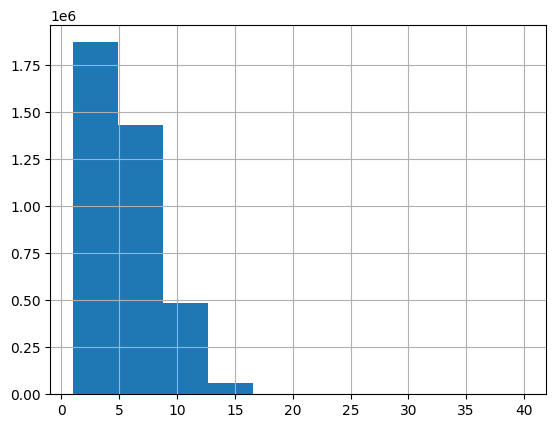

In [275]:
import pandas as pd
from tqdm import tqdm

results = []

for a, p in tqdm(df[["anchor", "positive"]].values):
    results += [len(x) for x in a.split()]
    results += [len(x) for x in p.split()]

temp = pd.Series(results)

print(temp.quantile([0.05,0.16,0.5,0.84, 0.95]))

temp.hist()

In [270]:
def remove_long_words(text, max_length=15):
    # Expressão regular para encontrar substrings com mais de 15 caracteres consecutivos
    pattern = r'\S{' + str(max_length + 1) + r',}'
    # Substituir as substrings que correspondem ao padrão por uma string vazia
    cleaned_text = re.sub(pattern, '', text)
    return cleaned_text

len("http://localhost:8888/lab/tree/09-finetune-embedding.ipynb")

58

In [272]:
remove_long_words("as http://localhost:8888/lab/tree/09-finetune-embedding.ipynb")

'as '

<Axes: >

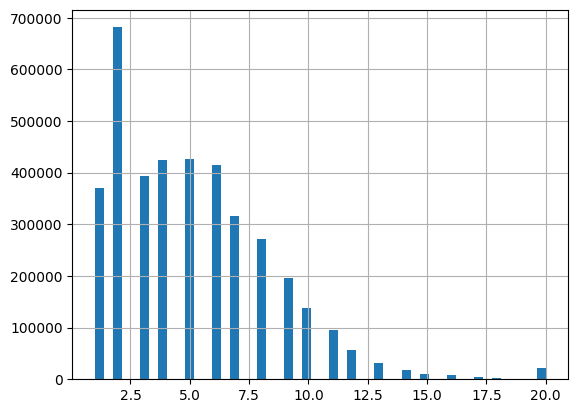

In [265]:
temp.clip(0,20).hist(bins=50)

In [260]:
print(temp.quantile([0.05,0.16,0.5,0.84, 0.99]))

0.05     1.0
0.16     2.0
0.50     5.0
0.84     8.0
0.99    15.0
dtype: float64


In [253]:
df

,anchor,positive,domain,len_anchor
0,"quanto custa um hotel para paws, claws, and co...","o preço médio para hotéis em paws, claws, and ...",kayak.com.br,50
1,Qual a loja da TIM Barão de Grajaú mais próxim...,A loja da TIM Barão de Grajaú mais próxima de ...,podecomparar.com.br,55
2,qual é a distância entre o holiday inn madrid ...,ao hospedar-te no holiday inn madrid - las tab...,momondo.pt,80
3,como posso encontrar voos baratos saindo de pi...,em edreams usamos técnicas de machine learning...,edreams.pt,75
4,os vossos menus podem contratar-se a partir de...,64,zankyou.pt,57
...,...,...,...,...
77842,quais são os melhores imóveis que aceitam anim...,os melhores aluguéis de temporada que aceitam ...,tripadvisor.com.br,90
77843,Ibis Rio de Janeiro Santos Dumont tem um rest...,Ibis Rio de Janeiro Santos Dumont tem 1 restau...,booking.com,63
77844,Como falar com um atendente Claro Jandaíra?,"Se você é cliente, ligue para o 106 99 ou 1052...",podecomparar.com.br,44
77845,econo lodge little creek oferece cancelamento ...,"sim, econo lodge little creek disponibiliza no...",hoteis.com,78


In [276]:
temp = df.sample(1).iloc[0].to_dict()
temp

{'anchor': 'quais as regras para gratuidade de ônibus na satélite norte, rápido marajó,  lopestur?',
 'positive': 'as viações permitem reserva de passagens de ônibus gratuitas para alguns tipos de viajantes.passagens gratuita para crianças com idade até 5 anos.saiba a documentação necessária para viajar com menores de idosos também possuem direito a gratuidade e descontos.veja\xa0mais informações sobre passagens de ônibus gratuitas para também gratuidade no ônibus para\xa0portadores de necessidades \xa0e jovens de baixa renda.',
 'domain': 'temonibus.com',
 'len_anchor': 86}

In [280]:
import unicodedata

unicodedata.normalize("NFKD",'as viações permitem reserva de passagens de ônibus gratuitas para alguns tipos de viajantes.passagens gratuita para crianças com idade até 5 anos.saiba a documentação necessária para viajar com menores de idosos também possuem direito a gratuidade e descontos.veja\xa0mais informações sobre passagens de ônibus gratuitas para também gratuidade no ônibus para\xa0portadores de necessidades \xa0e jovens de baixa renda.')

'as viações permitem reserva de passagens de ônibus gratuitas para alguns tipos de viajantes.passagens gratuita para crianças com idade até 5 anos.saiba a documentação necessária para viajar com menores de idosos também possuem direito a gratuidade e descontos.veja mais informações sobre passagens de ônibus gratuitas para também gratuidade no ônibus para portadores de necessidades  e jovens de baixa renda.'

In [239]:
temp = df[df['domain'] == "tripadvisor.pt"].sample(1).iloc[0].to_dict()
temp

{'anchor': 'que serviços no quarto estão disponíveis no monte santo resort?',
 'positive': 'os melhores serviços no quarto são kitchenette, ar-condicionado e televisão de ecrã plano. ver todos os serviços no quarto.hotel_review-g189115-d1107840-reviews-monte_santo_resort-carvoeiro_faro_district_algarve.html?m63287faqtshotel_reviewfaqtupgeo3a1891153bdetail3a1107840faqtt122faqtqr3',
 'domain': 'tripadvisor.pt',
 'len_anchor': 63}

In [204]:
len(df[df['domain'] == "ti-enxame.com"])

32

In [135]:
temp = df[
    (
        (df["len_anchor"] >= df["len_anchor"].quantile(0.95))
        & (df["len_anchor"] <= df["len_anchor"].quantile(0.99))
    )
].sample(1).iloc[0].to_dict()
temp

{'anchor': '### Quais são os melhores hotéis em Medina próximos a Aeroporto Internacional Príncipe Mohammad Bin Abdulaziz?',
 'positive': 'Os viajantes que ficaram em Medina próximos a Aeroporto Internacional Príncipe Mohammad Bin Abdulaziz (MED) fizeram bons comentários sobre [Millennium Madinah Airport](/hotel/sa/millennium-madinah-airport.pt-br.html?sid=c5327ac2c222c6a6ac262f2f0950d3f7), [فندق سوار](/hotel/sa/sewar.pt-br.html?sid=c5327ac2c222c6a6ac262f2f0950d3f7) e [فندق روائس](/hotel/sa/fndq-rwys.pt-br.html?sid=c5327ac2c222c6a6ac262f2f0950d3f7).',
 'len_anchor': 110}

In [125]:
len('hipertensos e diabéticos podem utilizar o mapa do site excit anais luxxxo gel lubrificante excitante anal premium ?')

115

<Axes: >

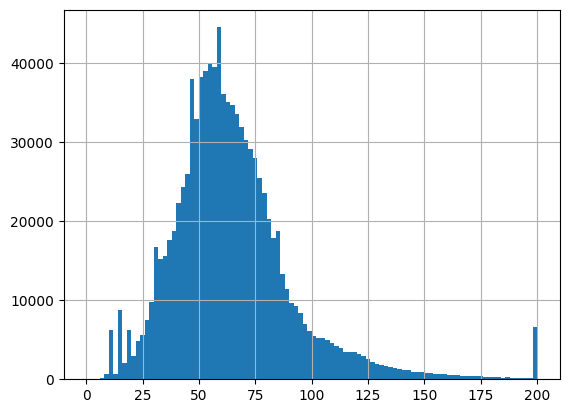

In [90]:
df["len_anchor"].clip(0,200).sample(1000000).hist(bins=100)

{'anchor': 'afeta os principais órgãos',
 'positive': 'o que a droga faz no corpo também é afetar os principais órgãos. é claro que todos os órgãos são indispensáveis para a sobrevivência do corpo humano. porém, há certos órgãos qu'}

In [55]:
dataset.save_to_disk("data/clips_mqa/pt")

Saving the dataset (0/8 shards):   0%|          | 0/6218943 [00:00<?, ? examples/s]

In [56]:
%%time




CPU times: user 111 ms, sys: 97.2 ms, total: 208 ms
Wall time: 61.1 ms


In [58]:
df = data.to_pandas()

In [66]:
df["is_accepted"].value_counts()

is_accepted
True     5964271
False     254672
Name: count, dtype: int64

{'id': 'aa5f6da9fce7e3be38ccd39a5c14af18',
 'text': '',
 'name': 'Quais são os hotéis mais económicos em Berkel en Rodenrijs?\n-----------------------------------------------------------\n\n',
 'domain': 'viamichelin.pt',
 'bucket': '2021.43',
 'answers': array([{'text': '[Hostel Ani&Haakien](https://www.viamichelin.pt/web/Hotel/Rotterdam-3014_LC-_-afwe6q3o), [Grand Hotel Central](https://www.viamichelin.pt/web/Hotel/Rotterdam-3012_EH-_-cqjvittp), [George&Ingrid Dinner&Bed](https://www.viamichelin.pt/web/Hotel/Nootdorp-2631_TA-_-9355b21b) fazem parte dos hotéis mais económicos Berkel en Rodenrijs. Pode reservar o seu quarto gratuitamente. Para obter os hotéis mais baratos, pode ordenar os resultados por preço crescente.\n\n', 'name': '', 'is_accepted': True}],
       dtype=object)}

{'id': '99ad47da0c43c59f88ae0ea0b010f6ea',
 'text': 'um certo liquido teve sua temperatura medida com dois termômetros x e y. o valor encontrado no termômetro x superou o termômetro y em 10 unidades. sabendo que os termômetros apresentam para o primeiro ponto fixo os valores -10°x e 20°y e, para o segundo ponto fixo os valores de 190°x e 270°y, determine a temperatura assinalada nos termômetros.\u200b',
 'name': 'um certo liquido teve sua temperatura medida com dois termômetros x e y. o valor encontrado no termômetro x superou o termômetro',
 'domain': 'br.com',
 'bucket': '2021.21',
 'answers': array([{'text': 'o valor de x é 30°x e o valor de y é 20°y.explicação:...', 'name': '', 'is_accepted': False}],
       dtype=object)}

In [34]:
temp["text"]

'um certo liquido teve sua temperatura medida com dois termômetros x e y. o valor encontrado no termômetro x superou o termômetro y em 10 unidades. sabendo que os termômetros apresentam para o primeiro ponto fixo os valores -10°x e 20°y e, para o segundo ponto fixo os valores de 190°x e 270°y, determine a temperatura assinalada nos termômetros.\u200b'

In [11]:
# Load dataset from the hub
dataset = load_dataset("Itau-Unibanco/FAQ_BACEN", split="train").select_columns(['questions', 'answers'])

# rename columns
dataset = dataset.rename_column("questions", "anchor")
dataset = dataset.rename_column("answers", "positive")

# Add an id column to the dataset
dataset = dataset.add_column("id", range(len(dataset)))

# split dataset into a 10% test set
dataset = dataset.train_test_split(test_size=0.1)

# save datasets to disk
dataset["train"].to_json(TRAIN_DATASET, orient="records")
dataset["test"].to_json(TEST_DATASET, orient="records")

Creating json from Arrow format:   0%|          | 0/2 [00:00<?, ?ba/s]

Creating json from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

89683

In [12]:
dataset["train"].to_pandas()

,anchor,positive,id
0,O que acontece se eu fornecer informações inco...,"Se, ao tentar realizar um Pix, algum erro ocor...",142
1,Como um investidor estrangeiro faz para regist...,Para fazer umRegistro Declaratório Eletrônico ...,365
2,Como são validados os atos processuais em meio...,"Mediante o uso de assinatura eletrônica, desde...",741
3,A liquidação antecipada com redução proporcion...,Não. Consórcios são uma forma de aquisição de ...,634
4,Quantos projetos foram inscritos no Ciclo 1 e ...,O Ciclo 1 do Sandbox BC recebeu a inscrição de...,707
...,...,...,...
1169,Qual a diferença entre o Pix e o DOC?,As mesmas diferenças existentes entre o Pix e ...,1044
1170,Quais são as instituições que enviam os dados ...,"As seguintes instituições, mesmo quando em liq...",378
1171,A instituição poderá devolver um valor diferen...,Sim. Poderá haver ajustes para mais ou para me...,745
1172,Qual é o prazo máximo de duração de um financi...,O Conselho Monetário Nacional e o Banco Centra...,608


In [4]:
# load test dataset
train_dataset = load_dataset("json", data_files=TRAIN_DATASET, split="train")
test_dataset = load_dataset("json", data_files=TEST_DATASET, split="train")
corpus_dataset = concatenate_datasets([train_dataset, test_dataset])

Generating train split: 0 examples [00:00, ? examples/s]

Generating train split: 0 examples [00:00, ? examples/s]

In [5]:

# Convert the datasets to dictionaries
corpus = dict(
    zip(corpus_dataset["id"], corpus_dataset["positive"])
)  # Our corpus (cid => document)
queries = dict(
    zip(test_dataset["id"], test_dataset["anchor"])
)  # Our queries (qid => question)

In [6]:
# Create a mapping of relevant document (1 in our case) for each query
relevant_docs = {}  # Query ID to relevant documents (qid => set([relevant_cids])
for q_id in queries:
    relevant_docs[q_id] = [q_id]


# Baseline

In [7]:
model = SentenceTransformer(
    MODEL_ID, device="cuda" if torch.cuda.is_available() else "cpu"
)

/opt/conda/lib/python3.10/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


In [8]:
%%time
matryoshka_evaluators = []
# Iterate over the different dimensions
for dim in MATRYOSHKA_DIMENSIONS:
    ir_evaluator = InformationRetrievalEvaluator(
        queries=queries,
        corpus=corpus,
        relevant_docs=relevant_docs,
        name=f"dim_{dim}",
        truncate_dim=dim,  # Truncate the embeddings to a certain dimension
        score_functions={"cosine": cos_sim},
    )
    matryoshka_evaluators.append(ir_evaluator)

# Create a sequential evaluator
evaluator = SequentialEvaluator(matryoshka_evaluators)



CPU times: user 512 µs, sys: 50 µs, total: 562 µs
Wall time: 527 µs


In [9]:
%%time

rerun_baseline = False

if rerun_baseline:
    results = evaluator(model)
    for dim in MATRYOSHKA_DIMENSIONS:
        key = f"dim_{dim}_cosine_ndcg@10"
        print
        print(f"{key}: {results[key]}")

dim_384_cosine_ndcg@10: 0.48615134942232113
dim_256_cosine_ndcg@10: 0.4821296819414081
dim_128_cosine_ndcg@10: 0.4359613779829637
dim_64_cosine_ndcg@10: 0.35929038216884834
CPU times: user 13.3 s, sys: 167 ms, total: 13.4 s
Wall time: 11 s


# Fine Tune

In [9]:
from sentence_transformers import SentenceTransformerModelCardData, SentenceTransformer

attn_implementation = "sdpa"# "eager" # sdpa

# load model with SDPA for using Flash Attention 2
model = SentenceTransformer(
    MODEL_ID,
    model_kwargs={"attn_implementation": attn_implementation},
    model_card_data=SentenceTransformerModelCardData(
        language="pt-br",
        license="apache-2.0",
        model_name="FAQ-BACEN",
    ),
)

In [10]:
from sentence_transformers.losses import MatryoshkaLoss, MultipleNegativesRankingLoss

inner_train_loss = MultipleNegativesRankingLoss(model)
train_loss = MatryoshkaLoss(
    model, inner_train_loss, matryoshka_dims=MATRYOSHKA_DIMENSIONS
)

In [11]:
from sentence_transformers import SentenceTransformerTrainingArguments
from sentence_transformers.training_args import BatchSamplers

# load train dataset again
train_dataset = load_dataset("json", data_files=TRAIN_DATASET, split="train")

# define training arguments
args = SentenceTransformerTrainingArguments(
    output_dir="./models/bacen/embeddings", # output directory and hugging face model ID
    num_train_epochs=10,                         # number of epochs
    per_device_train_batch_size=32,             # train batch size
    gradient_accumulation_steps=16,             # for a global batch size of 512
    per_device_eval_batch_size=16,              # evaluation batch size
    warmup_ratio=0.1,                           # warmup ratio
    learning_rate=2e-5,                         # learning rate, 2e-5 is a good value
    lr_scheduler_type="cosine",                 # use constant learning rate scheduler
    optim="adamw_torch_fused",                  # use fused adamw optimizer
    #tf32=True,                                  # use tf32 precision
    #bf16=True,                                  # use bf16 precision
    batch_sampler=BatchSamplers.NO_DUPLICATES,  # MultipleNegativesRankingLoss benefits from no duplicate samples in a batch
    eval_strategy="epoch",                      # evaluate after each epoch
    save_strategy="epoch",                      # save after each epoch
    logging_steps=10,                           # log every 10 steps
    save_total_limit=3,                         # save only the last 3 models
    load_best_model_at_end=True,                # load the best model when training ends
    metric_for_best_model="eval_dim_128_cosine_ndcg@10",  # Optimizing for the best ndcg@10 score for the 128 dimension
)

In [12]:
test = train_dataset.to_pandas().sample(1).iloc[0].to_dict()
print(f'anchor: {test["anchor"]}')
print(f'positive: {test["positive"]}')

anchor: Quais são os requisitos essenciais para a confirmação?
positive: A instituição transmissora de dados ou detentora de conta deve solicitar confirmação de compartilhamento ao cliente, assegurando-lhea possibilidade de discriminar o teor do compartilhamento. Importante! A confirmação deve ocorrer simultaneamente aos procedimentos para autenticação.


In [13]:
from sentence_transformers import SentenceTransformerTrainer

trainer = SentenceTransformerTrainer(
    model=model, # BAAI/bge-small-en-v1.5
    args=args,  # training arguments
    train_dataset=train_dataset.select_columns(
        ["positive", "anchor"]
    ),  # training dataset
    loss=train_loss,
    evaluator=evaluator,
)

In [14]:
# start training, the model will be automatically saved to the hub and the output directory
trainer.train()

# save the best model
trainer.save_model()

Epoch,Training Loss,Validation Loss,Dim 384 Cosine Accuracy@1,Dim 384 Cosine Accuracy@3,Dim 384 Cosine Accuracy@5,Dim 384 Cosine Accuracy@10,Dim 384 Cosine Precision@1,Dim 384 Cosine Precision@3,Dim 384 Cosine Precision@5,Dim 384 Cosine Precision@10,Dim 384 Cosine Recall@1,Dim 384 Cosine Recall@3,Dim 384 Cosine Recall@5,Dim 384 Cosine Recall@10,Dim 384 Cosine Ndcg@10,Dim 384 Cosine Mrr@10,Dim 384 Cosine Map@100,Dim 256 Cosine Accuracy@1,Dim 256 Cosine Accuracy@3,Dim 256 Cosine Accuracy@5,Dim 256 Cosine Accuracy@10,Dim 256 Cosine Precision@1,Dim 256 Cosine Precision@3,Dim 256 Cosine Precision@5,Dim 256 Cosine Precision@10,Dim 256 Cosine Recall@1,Dim 256 Cosine Recall@3,Dim 256 Cosine Recall@5,Dim 256 Cosine Recall@10,Dim 256 Cosine Ndcg@10,Dim 256 Cosine Mrr@10,Dim 256 Cosine Map@100,Dim 128 Cosine Accuracy@1,Dim 128 Cosine Accuracy@3,Dim 128 Cosine Accuracy@5,Dim 128 Cosine Accuracy@10,Dim 128 Cosine Precision@1,Dim 128 Cosine Precision@3,Dim 128 Cosine Precision@5,Dim 128 Cosine Precision@10,Dim 128 Cosine Recall@1,Dim 128 Cosine Recall@3,Dim 128 Cosine Recall@5,Dim 128 Cosine Recall@10,Dim 128 Cosine Ndcg@10,Dim 128 Cosine Mrr@10,Dim 128 Cosine Map@100,Dim 64 Cosine Accuracy@1,Dim 64 Cosine Accuracy@3,Dim 64 Cosine Accuracy@5,Dim 64 Cosine Accuracy@10,Dim 64 Cosine Precision@1,Dim 64 Cosine Precision@3,Dim 64 Cosine Precision@5,Dim 64 Cosine Precision@10,Dim 64 Cosine Recall@1,Dim 64 Cosine Recall@3,Dim 64 Cosine Recall@5,Dim 64 Cosine Recall@10,Dim 64 Cosine Ndcg@10,Dim 64 Cosine Mrr@10,Dim 64 Cosine Map@100,Sequential Score
0,No log,No log,0.297710,0.435115,0.534351,0.648855,0.297710,0.145038,0.106870,0.064885,0.297710,0.435115,0.534351,0.648855,0.458867,0.400376,0.411704,0.305344,0.450382,0.511450,0.610687,0.305344,0.150127,0.102290,0.061069,0.305344,0.450382,0.511450,0.610687,0.445961,0.394544,0.405385,0.267176,0.381679,0.442748,0.534351,0.267176,0.127226,0.088550,0.053435,0.267176,0.381679,0.442748,0.534351,0.388976,0.344093,0.356312,0.175573,0.305344,0.381679,0.526718,0.175573,0.101781,0.076336,0.052672,0.175573,0.305344,0.381679,0.526718,0.327233,0.266927,0.277323,0.277323
1,No log,No log,0.312977,0.465649,0.549618,0.687023,0.312977,0.155216,0.109924,0.068702,0.312977,0.465649,0.549618,0.687023,0.481379,0.417987,0.428616,0.320611,0.488550,0.534351,0.656489,0.320611,0.162850,0.106870,0.065649,0.320611,0.488550,0.534351,0.656489,0.475751,0.419405,0.429454,0.274809,0.419847,0.458015,0.564885,0.274809,0.139949,0.091603,0.056489,0.274809,0.419847,0.458015,0.564885,0.408680,0.360217,0.373267,0.183206,0.320611,0.404580,0.534351,0.183206,0.106870,0.080916,0.053435,0.183206,0.320611,0.404580,0.534351,0.340162,0.280443,0.293320,0.293320
2,No log,No log,0.343511,0.503817,0.595420,0.732824,0.343511,0.167939,0.119084,0.073282,0.343511,0.503817,0.595420,0.732824,0.517307,0.450800,0.457986,0.335878,0.488550,0.580153,0.679389,0.335878,0.162850,0.116031,0.067939,0.335878,0.488550,0.580153,0.679389,0.497347,0.440346,0.450411,0.305344,0.442748,0.496183,0.572519,0.305344,0.147583,0.099237,0.057252,0.305344,0.442748,0.496183,0.572519,0.430763,0.386066,0.401273,0.221374,0.351145,0.442748,0.564885,0.221374,0.117048,0.088550,0.056489,0.221374,0.351145,0.442748,0.564885,0.375011,0.316736,0.328438,0.328438
3,No log,No log,0.374046,0.564885,0.625954,0.717557,0.374046,0.188295,0.125191,0.071756,0.374046,0.564885,0.625954,0.717557,0.534360,0.476745,0.485630,0.351145,0.541985,0.595420,0.702290,0.351145,0.180662,0.119084,0.070229,0.351145,0.541985,0.595420,0.702290,0.519204,0.461708,0.470579,0.312977,0.450382,0.541985,0.641221,0.312977,0.150127,0.108397,0.064122,0.312977,0.450382,0.541985,0.641221,0.461871,0.406155,0.417056,0.244275,0.374046,0.488550,0.557252,0.244275,0.124682,0.097710,0.055725,0.244275,0.374046,0.488550,0.557252,0.388358,0.335663,0.349217,0.349217
4,6.996900,No log,0.389313,0.564885,0.625954,0.709924,0.389313,0.188295,0.125191,0.070992,0.389313,0.564885,0.625954,0.709924,0.538928,0.485063,0.494328,0.381679,0.541985,0.603053,0.6946

Computing widget examples:   0%|          | 0/1 [00:00<?, ?example/s]

In [16]:
from sentence_transformers import SentenceTransformer

fine_tuned_model = SentenceTransformer(
    args.output_dir, device="cuda" if torch.cuda.is_available() else "cpu"
)
# Evaluate the model
results = evaluator(fine_tuned_model)

# # COMMENT IN for full results
# print(results)

# Print the main score
for dim in MATRYOSHKA_DIMENSIONS:
    key = f"dim_{dim}_cosine_ndcg@10"
    print(f"{key}: {results[key]}")

dim_384_cosine_ndcg@10: 0.5457971333827764
dim_256_cosine_ndcg@10: 0.530200483332259
dim_128_cosine_ndcg@10: 0.47075116146773527
dim_64_cosine_ndcg@10: 0.40861102165257207


In [25]:
from sentence_transformers.util import cos_sim

sentences = [
    "Exemplo de sentença um.",
    "Exemplo de sentença um."
]

# Obter os embeddings
embeddings = fine_tuned_model.encode(sentences)
cos_sim(embeddings[0], embeddings[1])[0][0]

tensor(1.0000)

In [27]:
from sentence_transformers.util import cos_sim

sentences = [
    "O gato mordeu o cachorro",
    "O cachorro mordeu o gato."
]

# Obter os embeddings
embeddings = fine_tuned_model.encode(sentences)
cos_sim(embeddings[0], embeddings[1])[0][0]

tensor(0.9727)

In [28]:
from sentence_transformers.util import cos_sim

sentences = [
    "O gato mordeu o cachorro",
    "O gato mordeu o cão."
]

# Obter os embeddings
embeddings = fine_tuned_model.encode(sentences)
cos_sim(embeddings[0], embeddings[1])[0][0]

tensor(0.8039)

In [30]:
from sentence_transformers.util import cos_sim

sentences = [
    "O gato mordeu o cachorro",
    ""
]

# Obter os embeddings
embeddings = fine_tuned_model.encode(sentences)
cos_sim(embeddings[0], embeddings[1])[0][0]

tensor(0.4333)